### Import Libraries

In [721]:
# data wrangling
import pandas as pd
import numpy as np
import re, tweepy, string, emoji

In [722]:
# data exploration
from textblob import TextBlob
from wordcloud import WordCloud

In [723]:
# data cleaning
import nltk
from nltk.corpus import stopwords

### 1. Data Acquisition

In [724]:
# Twitter App access keys for the Twitter API

# Consume:
CONSUMER_KEY    = 'CONSUMER_KEY'
CONSUMER_SECRET = 'CONSUMER_SECRET'

# Access:
ACCESS_TOKEN  = 'ACCESS_TOKEN'
ACCESS_SECRET = 'ACCESS_SECRET'

In [725]:
def twitter_setup():
    
    # Authentication and access using user-specific keys
    authentication = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    authentication.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
    
    # Return API with authentication
    api = tweepy.API(authentication)
    return api

In [726]:
# Create object to get tweets
get_tweets = twitter_setup()

# initialization to hold list of tweets
tweets = []

# Initial request : get most recent 200 tweets and print
# API.user_timeline : Returns the  most recent statuses posted from the authenticating user or the user specified. 
posts = get_tweets.user_timeline(screen_name = "netflix", count = 200)

# Method that takes an iterable such as list, tuple, string etc
# save the tweets 
tweets.extend(posts)

# How to get more than 200 tweets #

# Save the id of the oldest tweet, less one
oldest = tweets[-1].id - 1

# Keep getting tweets until there are no more- or in this case, until we reach the limit
# Return the length number of an object
while len(posts) > 0:

    # All subsequent requests use the max_id parameter, to prevent getting duplicates
    # max_id :  Returns only statuses with an ID less than (that is, older than) or equal to the specified ID.
    posts = get_tweets.user_timeline(screen_name = "netflix", count = 200, max_id = oldest)
    
    # Save most recent
    tweets.extend(posts)
    
    # Update id of the oldest tweet, less one
    oldest = tweets[-1].id - 1
    
    print("...%s tweets downloaded so far" % (len(tweets)))

print("Number of tweets extracted: {}.\n".format(len(tweets)))

# Print most recent just to check
print("Most recent 5 tweets:\n")
for tweet in tweets[:5]:
    print(tweet.text)
    print()


...399 tweets downloaded so far
...596 tweets downloaded so far
...795 tweets downloaded so far
...993 tweets downloaded so far
...1189 tweets downloaded so far
...1389 tweets downloaded so far
...1587 tweets downloaded so far
...1787 tweets downloaded so far
...1986 tweets downloaded so far
...2183 tweets downloaded so far
...2379 tweets downloaded so far
...2579 tweets downloaded so far
...2776 tweets downloaded so far
...2969 tweets downloaded so far
...3163 tweets downloaded so far
...3166 tweets downloaded so far
...3166 tweets downloaded so far
Number of tweets extracted: 3166.

Most recent 5 tweets:

RT @NetflixNordic: Chess has never been this nail-biting. Norwegian Grandmaster and World Chess Champion @MagnusCarlsen breaks down Beth Ha…

RT @CobraKaiSeries: How's that New Year's resolution going? Yeah, that's what we thought. It’s time to #ChooseYourDojo and kick your ass in…

Grey's Anatomy offers up the best rationale for why you shouldn't date people you work with. https://

In [727]:
df = pd.DataFrame(data = [tweet.text for tweet in tweets], columns = ["tweet"])

In [728]:
df.head(10)

,tweet
0,RT @NetflixNordic: Chess has never been this n...
1,RT @CobraKaiSeries: How's that New Year's reso...
2,Grey's Anatomy offers up the best rationale fo...
3,"RT @NetflixFilm: PELÉ, a documentary from dire..."
4,@Most @NetflixFilm https://t.co/8dwVpvyYdk
5,Let's take a moment to celebrate Chance Perdom...
6,RT @MlKROTAEHYUNG: this is an ambrose spellman...
7,RT @iisamikaelson: one of the most important r...
8,@Most @contodonetflix truly on a loop
9,@HaleyReinhart forever a fan &lt;3


### 2. Data Cleaning and Pre-processing

#### 2.1 Remove Stopwords and Punctuations

In [729]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [730]:
from nltk.corpus import stopwords

In [731]:
stopwords = stopwords.words("english")

In [732]:
stopwords += list(string.punctuation)

In [733]:
alph = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
stopwords += alph

In [734]:
def preprocessing(posts):
    posts = str(posts).lower()
    posts = re.sub(r"@[A-Za-z0-9_]+", "", posts) #r- represent raw string
    posts = re.sub(r":", "", posts) #@username:, "...:"
    posts = re.sub(r"rt[\s]", "", posts)
    posts = re.sub(r"https?\/\/\S+", "", posts)
    posts = posts.replace("\n", "")
    posts = posts.replace('"', "")
    posts = posts.replace('', "")
    #posts = " ".join([item for item in str(posts).split() if item not in stopwords])- high memory
    tokens = nltk.word_tokenize(posts)
    posts = [token.lower() for token in tokens if token.lower() not in stopwords]
    return posts

In [735]:
df["tweet"] = df["tweet"].apply(preprocessing)

Reverse tokenization in order to extract more than one emojis in a sentence.

In [736]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [737]:
def detokenized(posts):
    posts = TreebankWordDetokenizer().detokenize(posts)
    return posts

In [738]:
df["tweet"] = df["tweet"].apply(detokenized)

In [739]:
df.head(10)

,tweet
0,chess never nail-biting norwegian grandmaster ...
1,'s new year's resolution going yeah's thought ...
2,grey's anatomy offers best rationalen't date p...
3,pelé documentary directors david tryhorn ben n...
4,
5,let's take moment celebrate chance perdomo's s...
6,ambrose spellman appreciation tweet sabrinanet...
7,one important relationship show 😭❤️ sabrinanet...
8,truly loop
9,forever fan lt 3


#### 2.2 Create Emoji Column

Extract emoji from every sentence using emoji.UNICODE_EMOJI.

In [740]:
def extract_emojis(posts):
    return ''.join(c for c in posts if c in emoji.UNICODE_EMOJI)

In [741]:
df['emoji'] = df.tweet.apply(extract_emojis)

In [742]:
df.head(50)

,tweet,emoji
0,chess never nail-biting norwegian grandmaster ...,
1,'s new year's resolution going yeah's thought ...,
2,grey's anatomy offers best rationalen't date p...,
3,pelé documentary directors david tryhorn ben n...,
4,,
5,let's take moment celebrate chance perdomo's s...,📺
6,ambrose spellman appreciation tweet sabrinanet...,
7,one important relationship show 😭❤️ sabrinanet...,😭❤
8,truly loop,
9,forever fan lt 3,


Remove emoji in a sentence after creating an emoji column.

In [743]:
def remove_emojis(posts):
    pattern = "[@!\w]+"
    return ' '.join(re.findall(pattern, posts))

In [744]:
df['tweet'] = df.tweet.apply(remove_emojis)

Check for missing values in emoji column.

In [745]:
df.emoji.isna().sum()

0

Count number of emoji in a sentence and create a new column.

In [746]:
def unique_emoji_count(posts):
    return len(set([c for c in posts]))

In [747]:
df['unique_emoji_count'] = df.emoji.apply(unique_emoji_count)

In [748]:
df.head(10)

,tweet,emoji,unique_emoji_count
0,chess never nail biting norwegian grandmaster ...,,0
1,s new year s resolution going yeah s thought t...,,0
2,grey s anatomy offers best rationalen t date p...,,0
3,pelé documentary directors david tryhorn ben n...,,0
4,,,0
5,let s take moment celebrate chance perdomo s s...,📺,1
6,ambrose spellman appreciation tweet sabrinanet...,,0
7,one important relationship show sabrinanetflix...,😭❤,2
8,truly loop,,0
9,forever fan lt 3,,0


Compute the sentiment score using vaderSentiment.vadeerSentiment library

In [749]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(posts):
    return analyzer.polarity_scores(posts)['compound']

In [750]:
df['sentiment_score'] = df.tweet.apply(sentiment_scores)

In [751]:
df.head(10)

,tweet,emoji,unique_emoji_count,sentiment_score
0,chess never nail biting norwegian grandmaster ...,,0,0.7430
1,s new year s resolution going yeah s thought t...,,0,-0.3182
2,grey s anatomy offers best rationalen t date p...,,0,0.6597
3,pelé documentary directors david tryhorn ben n...,,0,0.0000
4,,,0,0.0000
5,let s take moment celebrate chance perdomo s s...,📺,1,0.5719
6,ambrose spellman appreciation tweet sabrinanet...,,0,0.5106
7,one important relationship show sabrinanetflix...,😭❤,2,0.2023
8,truly loop,,0,0.4404
9,forever fan lt 3,,0,0.3182


Compute the usage of excalamation point in a sentence. The excalamation remarks can either show excitement, frustration or anger.

In [752]:
from tqdm import tqdm
tqdm.pandas()

c:\users\acer\appdata\local\programs\python\python38-32\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [753]:
def exclamation_percentage(posts):
    count = np.char.count(posts, sub ='!').sum()
    return count / len(posts)

In [754]:
df['exclamation_points'] = df.tweet.progress_apply(exclamation_percentage)

100%|███████████████████████████████████████████████████████████████████████████| 3166/3166 [00:00<00:00, 54589.94it/s]


In [755]:
df.head(10)

,tweet,emoji,unique_emoji_count,sentiment_score,exclamation_points
0,chess never nail biting norwegian grandmaster ...,,0,0.7430,0.0
1,s new year s resolution going yeah s thought t...,,0,-0.3182,0.0
2,grey s anatomy offers best rationalen t date p...,,0,0.6597,0.0
3,pelé documentary directors david tryhorn ben n...,,0,0.0000,0.0
4,,,0,0.0000,NaN
5,let s take moment celebrate chance perdomo s s...,📺,1,0.5719,0.0
6,ambrose spellman appreciation tweet sabrinanet...,,0,0.5106,0.0
7,one important relationship show sabrinanetflix...,😭❤,2,0.2023,0.0
8,truly loop,,0,0.4404,0.0
9,forever fan lt 3,,0,0.3182,0.0


Check for missing values in other columns.

In [756]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet               3166 non-null   object 
 1   emoji               3166 non-null   object 
 2   unique_emoji_count  3166 non-null   int64  
 3   sentiment_score     3166 non-null   float64
 4   exclamation_points  3045 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 99.0+ KB


exclamation_points column has several missing values, therefore, the missing values will be imputed by using mean value.

In [757]:
pd.options.mode.chained_assignment = None  # default='warn'

In [758]:
average_exclamationpoints = df["exclamation_points"].mean()

In [759]:
df["exclamation_points"][np.isnan(df["exclamation_points"])] = average_exclamationpoints

In [760]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3166 entries, 0 to 3165
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet               3166 non-null   object 
 1   emoji               3166 non-null   object 
 2   unique_emoji_count  3166 non-null   int64  
 3   sentiment_score     3166 non-null   float64
 4   exclamation_points  3166 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 99.0+ KB


Filter no-emoji data.

In [761]:
df = df[df.unique_emoji_count > 0]

In [762]:
df.reset_index(inplace = True)

In [763]:
df.head(10)

,index,tweet,emoji,unique_emoji_count,sentiment_score,exclamation_points
0,5,let s take moment celebrate chance perdomo s s...,📺,1,0.5719,0.0
1,7,one important relationship show sabrinanetflix...,😭❤,2,0.2023,0.0
2,13,ve never met anyone quite like marla grayson r...,🕶,1,0.4201,0.0
3,18,,❤,1,0.0000,0.0
4,19,nicolas cage screaming imaginary child named f...,📺,1,0.0772,0.0
5,22,already,😭😭,1,0.0000,0.0
6,23,boys 3 trailer finally ready boys always forev...,😍😭😍😭,2,0.3612,0.0
7,27,already love show mean god sake lupin,🖤🖤🖤,1,0.7430,0.0
8,31,meet parineeti chopra s girl train director s ...,🚆,1,0.1027,0.0
9,34,puggerton,🐝,1,0.0000,0.0


Count number of times used for every emoji.

In [764]:
df[(df.emoji.apply(len) == 1)].emoji.value_counts()[:30]

📺    37
❤    15
🎥    10
👀     9
💜     9
🥺     8
🤍     7
📽     7
😍     7
✨     6
🔥     5
🖤     5
🗣     4
🤝     4
😭     4
💕     3
📸     3
😂     3
🥰     3
💛     3
👑     3
📷     3
🍿     2
🌹     2
🤯     2
💯     2
🤣     2
💞     2
💝     2
😈     2
Name: emoji, dtype: int64

Define the emoji's expressions.

In [765]:
chill = ['📺']

In [766]:
#sad = ['😭', '😢', '😩', '😫', '😓', '😟', '🙁', '😞', '😔', '😣'] 

"Sad" emoji has been used to express different sentiment and mood. It sometimes indicated an overwhelm of feeling happiness, sarcasm and humor. Therefore, "Sad" expression has been excluded from the analysis since the purpose of sentiment analysis is to analyse positive-negative sentiment instead of mood detection.

In [767]:
fearful = [ '😱', '😰','😨'] 

In [768]:
angry = ['😡','😠','🤬']

In [769]:
happy = ['😊','🤗','😁','😌','😀','🙂','😄', '❤', '💜', '🤍', '🥰']

In [770]:
excited = ['👀', '😍', '😻', '😙', '👏']

In [771]:
annoyed = ['😒', '😑']

Condence multiple emojis exists in a sentence by using pop() function when raising the exception (-> only a single emoji).

In [772]:
def condence_emojis(posts):
    try:
        return set(posts).pop()
    except:
        return None

Create a dummy dataframe using copy() function to calculate the mean of emoji's sentiment score.

In [773]:
df2 = df.copy()
df2 = df2[df2.unique_emoji_count == 1]
df2['emoji'] = df2.emoji.apply(condence_emojis)
emoji_sentiment_mappings = df2[['emoji', 'sentiment_score']].groupby('emoji').mean()

Compute top emoji based on its sentiment score.

In [774]:
def impute_top_emoji(posts, mappings = emoji_sentiment_mappings, data = df):
    # Refer the emoji to the respective posts ("tweet")
    # Intialize the value as the sentiment_score of the first row
    val = df[df.emoji == posts].sentiment_score.values[0]
    
    # Assign posts ("tweet") to a list
    posts = list(set(posts))
    
    # Assign a dummy value
    closest = 100
    
    # Initialize the top sentiment_score
    top = posts[0]
    
    for i in range(0, len(posts)):
        try:
            if abs(val - emoji_sentiment_mappings.loc[posts[i]].sentiment_score) < closest:
                closest = abs(val - emoji_sentiment_mappings.loc[posts[i]].sentiment_score)
                top = posts[i]
        except:
            continue
    return top

In [775]:
df['top_emoji'] = df.emoji.progress_apply(impute_top_emoji)

100%|███████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 894.39it/s]


In [776]:
df.drop(["unique_emoji_count", "emoji"], axis=1, inplace=True)

In [777]:
df.drop(["index"], axis=1, inplace=True)

In [778]:
df.head(10)

,tweet,sentiment_score,exclamation_points,top_emoji
0,let s take moment celebrate chance perdomo s s...,0.5719,0.0,📺
1,one important relationship show sabrinanetflix...,0.2023,0.0,😭
2,ve never met anyone quite like marla grayson r...,0.4201,0.0,🕶
3,,0.0000,0.0,❤
4,nicolas cage screaming imaginary child named f...,0.0772,0.0,📺
5,already,0.0000,0.0,😭
6,boys 3 trailer finally ready boys always forev...,0.3612,0.0,😍
7,already love show mean god sake lupin,0.7430,0.0,🖤
8,meet parineeti chopra s girl train director s ...,0.1027,0.0,🚆
9,puggerton,0.0000,0.0,🐝


Compute the number of times or frequency of emoji has been used.

In [779]:
emoji_counts = dict(df.top_emoji.value_counts()) #key-value: emoji-count

In [780]:
df['emoji_frequency'] = df.top_emoji.map(emoji_counts)

In [781]:
df.head(10)

,tweet,sentiment_score,exclamation_points,top_emoji,emoji_frequency
0,let s take moment celebrate chance perdomo s s...,0.5719,0.0,📺,37
1,one important relationship show sabrinanetflix...,0.2023,0.0,😭,14
2,ve never met anyone quite like marla grayson r...,0.4201,0.0,🕶,2
3,,0.0000,0.0,❤,27
4,nicolas cage screaming imaginary child named f...,0.0772,0.0,📺,37
5,already,0.0000,0.0,😭,14
6,boys 3 trailer finally ready boys always forev...,0.3612,0.0,😍,12
7,already love show mean god sake lupin,0.7430,0.0,🖤,10
8,meet parineeti chopra s girl train director s ...,0.1027,0.0,🚆,1
9,puggerton,0.0000,0.0,🐝,1


Save the data.

In [782]:
df.to_csv("emoji sentiment.csv")

Plot sentiment score for an overview.

In [783]:
import seaborn as sns

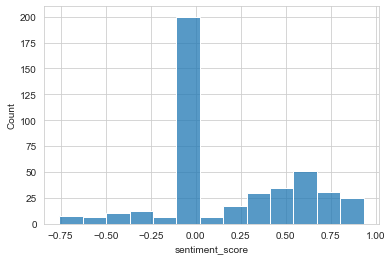

In [784]:
sns.histplot(df.sentiment_score)

Potray sentiment score overview.

In [786]:
print("Sentiments for chill")
for i in range(0,len(chill)):
    print(df[df.top_emoji==chill[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for fearful")
for i in range(0,len(fearful)):
    print(df[df.top_emoji==fearful[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for angry")
for i in range(0,len(angry)):
    print(df[df.top_emoji==angry[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for happy")
for i in range(0,len(happy)):
    print(df[df.top_emoji==happy[i]].sentiment_score.mean())
print("----------------------")
print("Sentiments for excited")
for i in range(0,len(excited)):
    print(df[df.top_emoji==excited[i]].sentiment_score.mean()) 
print("----------------------")
print("Sentiments for annoyed")
for i in range(0,len(annoyed)):
    print(df[df.top_emoji==annoyed[i]].sentiment_score.mean())

Sentiments for chill
0.1736594594594595
----------------------
Sentiments for fearful
0.0
nan
nan
----------------------
Sentiments for angry
nan
nan
nan
----------------------
Sentiments for happy
nan
0.4588
0.2732
-0.5574
nan
nan
0.6369
0.28625555555555554
0.07771666666666664
0.3237076923076923
0.5691333333333334
----------------------
Sentiments for excited
-0.09379090909090909
0.3056083333333333
nan
nan
0.142575
----------------------
Sentiments for annoyed
nan
nan


Filter emoji based on the defined expressions.

In [788]:
all_e = chill + fearful + angry + happy + excited + annoyed

In [789]:
new_df = df[df.top_emoji.isin(all_e)]

Create a dictionary for defined emoji-expression and its count to be assigned to exsiting "emoji_frequency" column.

In [790]:
conditions = [
    new_df.top_emoji.isin(chill[1:]),
    new_df.top_emoji.isin(fearful[1:]),
    new_df.top_emoji.isin(angry[1:]),
    new_df.top_emoji.isin(happy[1:]),
    new_df.top_emoji.isin(excited[1:]),
    new_df.top_emoji.isin(annoyed[1:])
    
]

choices = [
    chill[0],
    fearful[0],
    angry[0], 
    happy[0],
    excited[0],
    annoyed[0]
]

new_df.top_emoji = np.select(conditions, choices, default = new_df.top_emoji)

In [791]:
new_df.top_emoji.value_counts()

😊    65
👀    39
📺    37
😱     2
Name: top_emoji, dtype: int64

In [792]:
new_df.drop('emoji_frequency', axis=1, inplace=True)
freq_map = dict(new_df.top_emoji.value_counts())
new_df['emoji_frequency'] = new_df.top_emoji.map(freq_map)

new_df.to_csv("tweets_4_classes.csv")

In [793]:
emojis = new_df.groupby('top_emoji').mean()
emojis.to_csv("emojis_NEW.csv")

In [794]:
emojis

,sentiment_score,exclamation_points,emoji_frequency
top_emoji,,,
👀,0.126072,0.0,39
📺,0.173659,0.0,37
😊,0.289283,0.0,65
😱,0.000000,0.0,2


### 3. Data Exploration and Visualization

#### Emoji Comparison

Plot the emoji according to its count and sentiment score.

In [795]:
# Download emoji.png
pics = ["image/excited.png", "image/chill.png", "image/happy.png", "image/fearful.png"]

In [796]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [797]:
def getImage(path):
    return OffsetImage(plt.imread(path, 0))

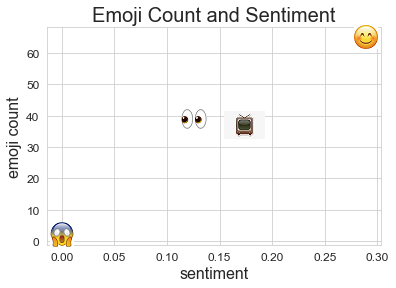

In [798]:
fig, ax = plt.subplots(figsize = (6,4))

sns.scatterplot(x=emojis.sentiment_score, y=emojis.emoji_frequency, ax=ax)
sns.set_style("whitegrid")
plt.xticks(fontsize=12)
plt.xlabel('sentiment', fontsize=16)
plt.yticks(fontsize=12)
plt.ylabel('emoji count', fontsize=16)
plt.title("Emoji Count and Sentiment", fontsize = 20)

for x0, y0, pic in zip(emojis.sentiment_score, emojis.emoji_frequency,pics):
    ab = AnnotationBbox(getImage(pic), (x0, y0), frameon=False)
    ax.add_artist(ab)
plt.savefig('image/emoji_count_and_sentiment.png')
plt.show()

Compute the subjectivity of the tweet based on the top emoji (in new_df).

In [799]:
def get_subjectivity(posts):
    b = TextBlob(posts)
    return b.sentiment.subjectivity

In [800]:
new_df['subjectivity'] = new_df.tweet.progress_apply(get_subjectivity)

100%|██████████████████████████████████████████████████████████████████████████████| 143/143 [00:00<00:00, 3502.70it/s]


In [801]:
emoji_counts = dict(new_df.top_emoji.value_counts())

In [802]:
new_df['emoji_frequency'] = new_df.top_emoji.map(emoji_counts)

In [803]:
new_df.head(10)

,tweet,sentiment_score,exclamation_points,top_emoji,emoji_frequency,subjectivity
0,let s take moment celebrate chance perdomo s s...,0.5719,0.0,📺,37,0.900000
3,,0.0000,0.0,😊,65,0.000000
4,nicolas cage screaming imaginary child named f...,0.0772,0.0,📺,37,0.000000
6,boys 3 trailer finally ready boys always forev...,0.3612,0.0,👀,39,0.500000
10,know rakes brush regency slang cast bridgerton,0.0000,0.0,👀,39,0.000000
12,said needed riskyairlines lying chris rock tot...,-0.6705,0.0,👀,39,0.750000
13,amanda larusso exactly kind smart strong carin...,0.9325,0.0,📺,37,0.631548
25,one regé jean page bridgerton,0.0000,0.0,👀,39,0.000000
26,,0.0000,0.0,😊,65,0.000000
27,,0.0000,0.0,👀,39,0.000000


Create wordcloud from the emoji's expressions.

In [804]:
from nltk.probability import FreqDist

In [805]:
def make_word_cloud(new_df, emoji, emoji_expression):
    df_freq = new_df[new_df['top_emoji']==emoji]
    data = df_freq['tweet']
    processed = list(map(preprocessing, data))
    
    #flat = [item.split() for item in processed]- the data were already in list
    flat_2 = []
    for row in processed:
        for word in row:
            flat_2.append(word)
    freq = FreqDist(flat_2)
    
    # Top 40 most common words
    bar_counts = [x[1] for x in freq.most_common(40)]
    bar_words = [x[0] for x in freq.most_common(40)]
    
    dictionary = dict(zip(bar_words, bar_counts))
    
    # Create the word cloud:
    wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(dictionary)
    # Display the generated image w/ matplotlib:
    plt.figure(figsize=(6,6), facecolor='k')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    plt.show()

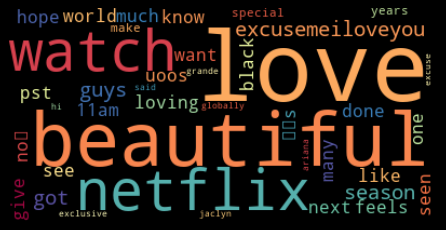

In [811]:
make_word_cloud(new_df, '😊', 'happy')

In [812]:
for item in new_df[new_df.top_emoji == '😊'].tweet:
    print(item)
    print('-----------------------------------------------------------------------------------------------------')


-----------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------
hi jaclyn
-----------------------------------------------------------------------------------------------------
hope loving excusemeiloveyou
-----------------------------------------------------------------------------------------------------
l o v i n g
-----------------------------------------------------------------------------------------------------
see like want got s excuse love netflix globally
-----------------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------

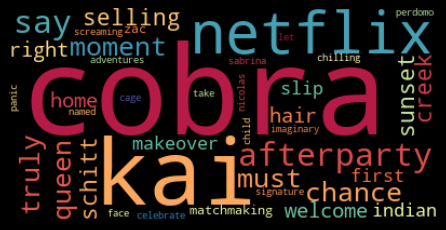

In [813]:
make_word_cloud(new_df, '📺', 'chill')

In [814]:
for item in new_df[new_df.top_emoji == '📺'].tweet:
    print(item)
    print('-----------------------------------------------------------------------------------------------------')

let s take moment celebrate chance perdomo s signature panic face chilling adventures sabrina
-----------------------------------------------------------------------------------------------------
nicolas cage screaming imaginary child named fucklyn truly something must witness history s
-----------------------------------------------------------------------------------------------------
amanda larusso exactly kind smart strong caring badass daniel would married cobra kai
-----------------------------------------------------------------------------------------------------
problem bridgerton
-----------------------------------------------------------------------------------------------------
cobra kai star mary mouser unique rule comes on screen kisses netflix afterparty
-----------------------------------------------------------------------------------------------------
love queen loves gossip
----------------------------------------------------------------------------------------------

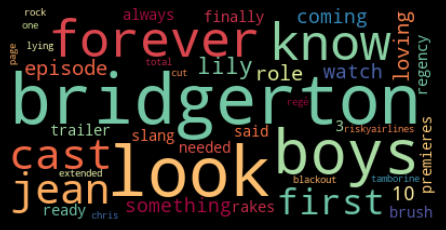

In [815]:
make_word_cloud(new_df, '👀', 'excited')

In [816]:
for item in new_df[new_df.top_emoji == '👀'].tweet:
    print(item)
    print('-----------------------------------------------------------------------------------------------------')

boys 3 trailer finally ready boys always forever premieres
-----------------------------------------------------------------------------------------------------
know rakes brush regency slang cast bridgerton
-----------------------------------------------------------------------------------------------------
said needed riskyairlines lying chris rock total blackout tamborine extended cut d
-----------------------------------------------------------------------------------------------------
one regé jean page bridgerton
-----------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------
phoebedynevor bridgerton
-----------------------------------------------------------------------------------------------------
hey thanks bridgerton love
-----------------------------------------------------------------------------------------------------

-------------

There were no "fear" traced within the tweets.

#### Sentiment Analysis

In [817]:
new_df.groupby('top_emoji').mean().sentiment_score

top_emoji
👀    0.126072
📺    0.173659
😊    0.289283
😱    0.000000
Name: sentiment_score, dtype: float64

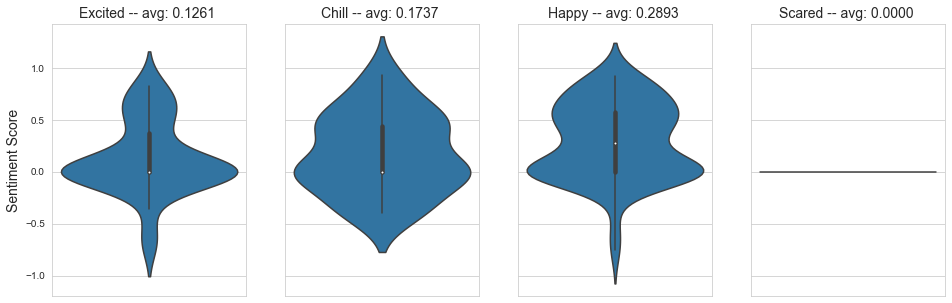

In [823]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True, )
titles = ['Excited', 'Chill', 'Happy', 'Scared']

# Plot the mean of sentiment score
for i, emoji in enumerate(new_df.groupby('top_emoji').mean().sentiment_score.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].sentiment_score, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].sentiment_score.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)
    if i == 0:
        axes[i].set_ylabel("Sentiment Score", fontsize=14)
    else:
        axes[i].set_ylabel("")

plt.show()

"Chill" expression has the largest distribution in violinplot. Almost all mentioned tweets have 📺 emoji which indicated the awareness of Netflix's trademark. It could also indicate the strong engagement between the users and Netflix where the sentiment scores have been proved to be high.

#### Subjectivity

In [91]:
new_df.groupby('top_emoji').mean().subjectivity

top_emoji
👀    0.233974
📺    0.329595
😊    0.348856
😢    0.394444
😱    0.000000
Name: subjectivity, dtype: float64

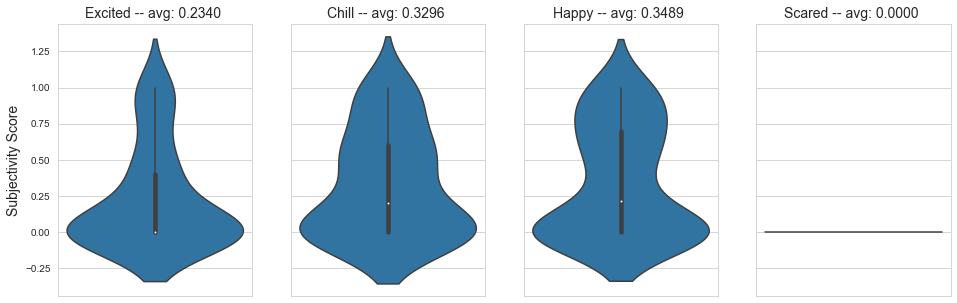

In [824]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,5), sharey=True, )
titles = ['Excited', 'Chill', 'Happy', 'Scared']

# Plot the mean of subjectivity
for i, emoji in enumerate(new_df.groupby('top_emoji').mean().subjectivity.index):
    sns.violinplot(y=new_df[new_df.top_emoji==emoji].subjectivity, ax=axes[i])
    val = new_df[new_df.top_emoji == emoji].subjectivity.mean()
    axes[i].set_title(f"{titles[i]} -- avg: {val:.4f} ", fontsize=14)    
    if i == 0:
        axes[i].set_ylabel("Subjectivity Score", fontsize=14)
    else:
        axes[i].set_ylabel("")

plt.show()

Subjectivity indicates the strength of opinion existed in tweets. It can be seeen that "excited" expression has the strongest and consistent subjectivity. The users showed a strong feeling of excitement and anticipation which could indicate that the users have something to look forward to. 

#### Exclamation Points

In [821]:
new_df.groupby('top_emoji').mean().exclamation_points

top_emoji
👀    0.0
📺    0.0
😊    0.0
😱    0.0
Name: exclamation_points, dtype: float64

There were no exclamation remarks made within the tweets.

### Acknowledgement:
https://github.com/Laodamia/Data-Portfolio/blob/master/Twitter-data/JAM-Tweets.ipynb
https://github.com/LiyanaKharulaman/Emoji_Analysis/blob/main/Analysis/Exploratory_Analysis_NEW.ipynb